In [11]:
import glob
import logging
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sqlalchemy import create_engine

from ppcx_pymc_func import (
    assign_spatial_priors,
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
    plot_spatial_priors,
)
from src.clustering import preproc_features
from src.config import ConfigManager
from src.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_image,
    get_multi_dic_data,
)
from src.logger import setup_logger
from src.preprocessing import apply_dic_filters, spatial_subsample
from src.roi import PolygonROISelector

%matplotlib widget

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
logger = setup_logger(logging.INFO, name="ppcx", force=True)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)


In [12]:
# Flags to control workflow
SAVE_OUTPUTS = False  # Set to True to save inference results
LOAD_EXISTING = False  # Set to False to run sampling again

# MCMC parameters
DRAWS = 1000  # Number of MCMC draws
TUNE = 500  # Number of tuning steps
CHAINS = 4  # Number of MCMC chains
CORES = 4  # Number of CPU cores to use
TARGET_ACCEPT = 0.9  # Target acceptance rate for NUTS sampler

# Data selection parameters
camera_name = "PPCX_Tele"
reference_start_date = "2024-07-23"
reference_end_date = "2024-08-28"

SUBSAMPLE_FACTOR = 1  # Take every n point
SUBSAMPLE_METHOD = "regular"  # or 'random', 'stratified'
PRIOR_STRENGTH = 0.4  # Between 0 and 1

# Output paths
output_dir = Path("output") / f"{camera_name}_PyMC"
output_dir.mkdir(parents=True, exist_ok=True)
base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)

# Get DIC analysis metadata
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
)
if len(dic_ids) < 1:
    raise ValueError("No DIC analyses found for the given criteria")

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

In [13]:
# Fetch DIC data
out = get_multi_dic_data(dic_ids, stack_results=False)
logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")

# Apply filter for each df in the dictionary and then stack them
filter_kwargs = dict(
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
    min_velocity=config.get("dic.min_velocity"),
    apply_2d_median=config.get("dic.apply_2d_median"),
    median_window_size=config.get("dic.median_window_size"),
    median_threshold_factor=config.get("dic.median_threshold_factor"),
)
processed = []
for src_id, df_src in out.items():
    try:
        processed.append(apply_dic_filters(df_src, **filter_kwargs))
    except Exception as exc:
        logger.warning("Filtering failed for %s: %s", src_id, exc)
if not processed:
    raise RuntimeError("No dataframes left after filtering.")
df = pd.concat(processed, ignore_index=True)
logger.info("Data shape after filtering and stacking: %s", df.shape)

# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logger.info(f"Data shape after filtering: {df.shape}")

# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 0:
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# === FEATURE PREPARATION ===
variables_names = config.get("clustering.variables_names")
logger.info(f"Using features: {variables_names}")
df_features = preproc_features(df)
X = df_features[variables_names].values
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
n_features = X_scaled.shape[1]
ndata = X_scaled.shape[0]
logger.info(f"Feature matrix shape: {X_scaled.shape}")

2025-09-11 17:03:48 | [INFO    ] Found stack of 6 DIC dataframes. Run filtering...
2025-09-11 17:03:51 | [INFO    ] Data shape after filtering and stacking: (20994, 5)
2025-09-11 17:03:51 | [INFO    ] Data shape after filtering: (11233, 5)
2025-09-11 17:03:51 | [INFO    ] Data shape after subsampling: (11233, 5)
2025-09-11 17:03:51 | [INFO    ] Using features: ['V']
2025-09-11 17:03:51 | [INFO    ] Feature matrix shape: (11233, 1)


Filtered 20994 points to 11233 points inside polygon
Subsampled from 11233 to 11233 points (100.0%)


2025-09-11 17:03:51 | [INFO    ] Found 4 sector polygons for priors
2025-09-11 17:03:51 | [INFO    ] Sector 0: 1238 points with strong prior
2025-09-11 17:03:51 | [INFO    ] Sector 1: 2141 points with strong prior
2025-09-11 17:03:51 | [INFO    ] Sector 2: 2245 points with strong prior
2025-09-11 17:03:51 | [INFO    ] Sector 3: 4976 points with strong prior


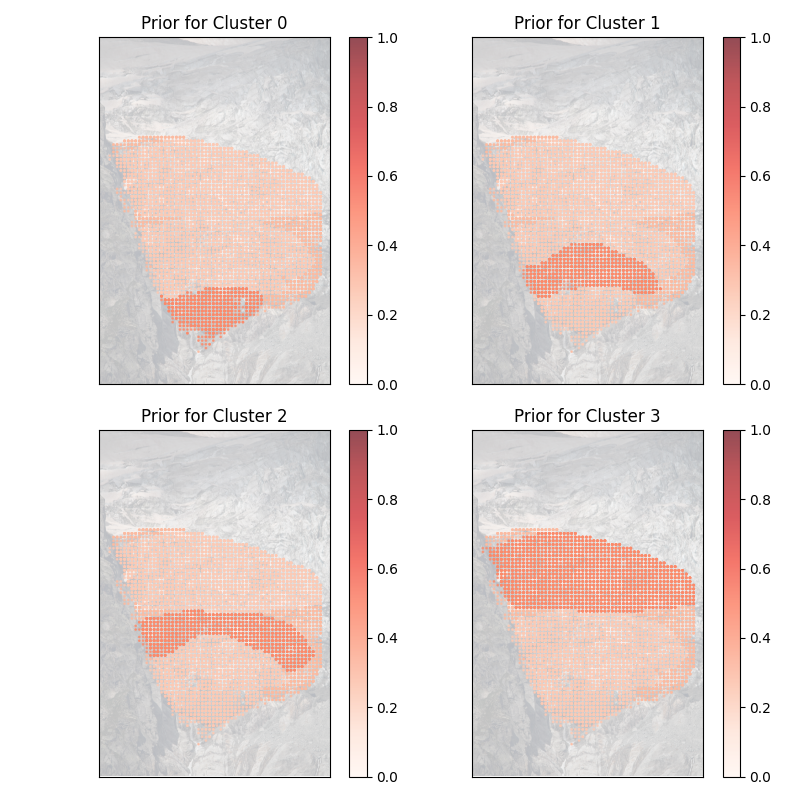

In [14]:
# === SPATIAL PRIOR SETUP ===
sector_files = sorted(glob.glob(config.get("data.sector_prior_pattern")))
sectors = [PolygonROISelector.from_file(f) for f in sector_files]
k = len(sectors)  # number of clusters = number of sectors
logger.info(f"Found {k} sector polygons for priors")

prior_probs = assign_spatial_priors(df, sectors, prior_strength=PRIOR_STRENGTH)
plot_spatial_priors(df, prior_probs, img=img);

In [ ]:
# # Simple, not marginalized model (z discrete) --> slower sampling, but direct cluster assignments
# with pm.Model(
#     coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
# ) as simple_model:
#     # Cluster means
#     μ = pm.Normal("μ", mu=0, sigma=1, dims=("cluster", "feature"))

#     # Cluster standard deviations (diagonal covariance)
#     σ = pm.HalfNormal("σ", sigma=0.5, dims=("cluster", "feature"))

#     # Cluster assignments with spatial priors
#     z = pm.Categorical("z", p=prior_probs, dims="obs")

#     # Likelihood: each point comes from its assigned cluster
#     observations = pm.Normal(
#         "x_obs", mu=μ[z], sigma=σ[z], observed=X_scaled, dims=("obs", "feature")
#     )

# with simple_model:
#     prior_samples = pm.sample_prior_predictive(100)

# fig, ax = plt.subplots(figsize=(8, 4))
# az.plot_dist(
#     X_scaled,
#     kind="hist",
#     color="C1",
#     hist_kwargs={"alpha": 0.6},
#     label="observed",
# )
# az.plot_dist(
#     prior_samples.prior_predictive["x_obs"],
#     kind="hist",
#     hist_kwargs={"alpha": 0.6},
#     label="simulated",
# )
# plt.xticks(rotation=45);

In [16]:
# Marginalized mixture model (no discrete z) --> faster sampling, but no direct cluster assignments
with pm.Model(
    coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
) as model:
    # cluster parameters (continuous only)
    mu = pm.Normal("mu", mu=0, sigma=1, dims=("cluster", "feature"))
    sigma = pm.HalfNormal("sigma", sigma=0.5, dims=("cluster", "feature"))

    # register data as pm.Data so you can reuse the model and call pm.set_data
    X_shared = pm.Data("X_shared", X_scaled)  # shape (ndata, n_features)
    priors_shared = pm.Data("priors_shared", prior_probs)  # shape (ndata, k)

    # compute per-observation, per-component log-likelihood (diagonal cov assumed)
    # shapes: X_shared (ndata, 1, feature), mu (1, k, feature) -> broadcast to (ndata, k, feature)
    diff = X_shared[:, None, :] - mu[None, :, :]  # (ndata, k, feature)
    inv_sigma = 1.0 / sigma[None, :, :]  # (1, k, feature)
    sq = (diff * inv_sigma) ** 2

    # Normal logpdf per feature: -0.5 * ((x-mu)/sigma)^2 - log(sigma) - 0.5*log(2π)
    log_comp_feat = (
        -0.5 * sq - pm.math.log(sigma)[None, :, :] - 0.5 * pm.math.log(2 * np.pi)
    )
    log_comp = log_comp_feat.sum(axis=2)  # (ndata, k)

    # add log spatial priors and marginalize via logsumexp
    log_priors = pm.math.log(priors_shared + 1e-12)  # (ndata, k)
    log_mixture_per_obs = pm.math.logsumexp(log_priors + log_comp, axis=1)  # (ndata,)

    # add total log-likelihood as a potential (no discrete z variable)
    mixture_likelihood = pm.Potential("mixture_likelihood", log_mixture_per_obs.sum())

logger.info("Marginalized mixture model created (no discrete z).")


2025-09-11 17:04:03 | [INFO    ] Marginalized mixture model created (no discrete z).


In [17]:
# Sampling (now NUTS can be used for mu, sigma)
posterior_path = output_dir / f"{base_name}_posterior.idata.nc"
if LOAD_EXISTING is False or not posterior_path.exists():
    with model:
        logger.info("Starting MCMC sampling...")
        idata = pm.sample(
            target_accept=TARGET_ACCEPT,
            draws=DRAWS,
            tune=TUNE,
            chains=CHAINS,
            cores=CORES,
            random_seed=RANDOM_SEED,
        )
    logger.info("Sampling completed!")

    # save the posterior InferenceData object and the scaler
    if SAVE_OUTPUTS:
        az.to_netcdf(idata, posterior_path)
        joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")
        logger.info(f"Outputs saved to {output_dir}")
else:
    logger.info("Loading existing posterior InferenceData object...")
    idata = az.from_netcdf(posterior_path)

2025-09-11 17:04:06 | [INFO    ] Starting MCMC sampling...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 204 seconds.
2025-09-11 17:07:31 | [INFO    ] Sampling completed!


In [18]:
az.summary(idata, var_names=["mu", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu[0, 0]",0.043,0.016,0.014,0.076,0.000,0.0,2731.0,2823.0,1.0
"mu[1, 0]",0.661,0.025,0.613,0.708,0.001,0.0,2459.0,2822.0,1.0
"mu[2, 0]",0.238,0.026,0.189,0.288,0.001,0.0,2185.0,2104.0,1.0
"mu[3, 0]",-0.903,0.010,-0.923,-0.885,0.000,0.0,3470.0,3019.0,1.0
"sigma[0, 0]",0.256,0.010,0.237,0.274,0.000,0.0,3436.0,3116.0,1.0
"sigma[1, 0]",0.557,0.017,0.527,0.591,0.000,0.0,2562.0,2912.0,1.0
"sigma[2, 0]",0.388,0.015,0.360,0.417,0.000,0.0,2876.0,2622.0,1.0
"sigma[3, 0]",0.377,0.007,0.364,0.390,0.000,0.0,3187.0,3153.0,1.0


In [12]:
# Check R-hat (should be < 1.01)
print("R-hat values (should be < 1.01):")
rhat = az.rhat(idata)
print("\tμ values:", rhat.mu.values.flatten())
print("\tσ values:", rhat.sigma.values.flatten())

# Check effective sample size (should be > 100)
print("Effective sample size (should be > 100):")
ess = az.ess(idata)
print("\tμ values:", ess.mu.values.flatten())
print("\tσ values:", ess.sigma.values.flatten())

R-hat values (should be < 1.01):
	μ values: [1.0022286  1.00162569 1.00072325 1.00050864]
	σ values: [0.99974755 1.00122818 1.00091405 1.00048225]
Effective sample size (should be > 100):
	μ values: [4162.62233323 3901.88703168 3890.59812093 4575.31023299]
	σ values: [5445.31572866 4108.85168365 4518.50330442 4790.67082269]


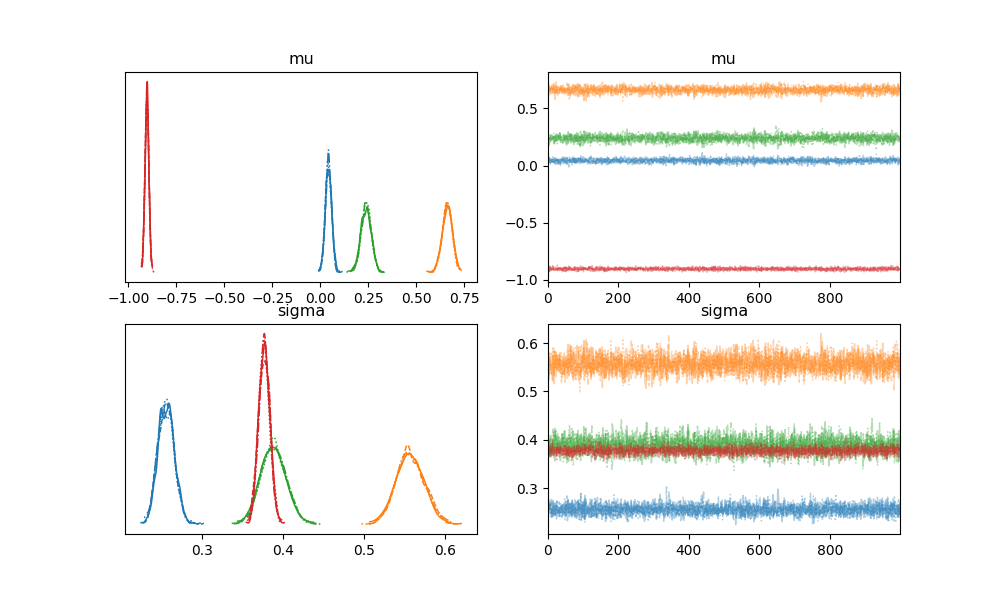

In [19]:
# Plot trace plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
az.plot_trace(idata, var_names=["mu", "sigma"], axes=axes, compact=True)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_trace_plots.png", dpi=150)

In [14]:
## === POSTERIOR ANALYSIS: ASSIGN POINTS TO CLUSTERS ===

# compute cluster assignments (subsample 200 posterior draws to save time)
posterior_probs, cluster_pred, uncertainty = compute_posterior_assignments(
    idata, X_scaled, prior_probs, n_posterior_samples=200
)
fig, uncertainty = plot_1d_velocity_clustering(
    df_features,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
if SAVE_OUTPUTS:
    fig.savefig(output_dir / f"{base_name}_results.png", dpi=300, bbox_inches="tight")

KeyError: "No variable named 'μ'. Variables on the dataset include ['chain', 'draw', 'cluster', 'feature', 'mu', 'sigma']"